# Music Recommender System
##### By: Darren Lam Kin Teng

This personal project will help me apply what I have learnt about matrix factorization and the different applications of machine learning - in this case building a recommender system.

The data for this project has been gathered from grouplens: "Movie Lens".
Link: https://grouplens.org/datasets/movielens/.
This dataset is commonly used for research studies and personalised recommendation systems, like this personal project.

In [2]:
import pandas as pd
import numpy as np
from itertools import islice

# Importing svd from scipy for matrix factorization
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix

# Sklearn metrics
from sklearn.metrics import mean_squared_error

# import explorattory data analysis and visualisation libraries
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

# import datime
import datetime

# Import model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors

C:\Users\darre\AppData\Local\Temp\ipykernel_26808\3788382572.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Defining functions we will use

In [3]:
def sparsity(dataframe):
    '''
    The function sparsity takes in a dataframe and prints an integer representing the
    dataframe sparsity.
    '''
    total_cells = dataframe.size
    empty_cells = dataframe.isna().sum().sum()
    answer = empty_cells/total_cells * 100
    print('The dataframe sparsity is: {:.2f}%'.format(answer))    

## Data Manipulation

Importing the dataset: <br />
The website provided us with both a large dataset and a small dataset. For the purpose of this project, we will use the small dataset due to: <br /> 
* limited computational resources<br />
* time constraints (small datasets train and run faster)<br />
* this project is for my educational purposes<br />

In [4]:
movies = pd.read_csv('./data/movies.csv')
ratings  = pd.read_csv('./data/ratings.csv')

print(
    '''
    Here are the sizes and shape of the dataset available to us:
    movies:
        shape: {0}
        size: {1}

    ratings:
        shape: {2}
        size: {3}
    '''.format(movies.shape, movies.size,\
                ratings.shape, ratings.size))


    Here are the sizes and shape of the dataset available to us:
    movies:
        shape: (9742, 3)
        size: 29226

    ratings:
        shape: (100836, 4)
        size: 403344
    


#### Let us view a sample of each dataset

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [7]:
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

We can start combining the datasets for our metadata.
We must identify the primary keys and foreign keys before merging datasets.

movies: </br >
PK: `movieId`

ratings: </br >
PK: `userId`, `movieId`

</br>
Based on the description of the dataset `links` provided in the README.txt file, columns imdbId and tmdbId refer to the links of the movies from imdb and movielens. This dataset does not provide much valuable information so we will omit it from our dataset.

In [8]:
movies_ratings = pd.merge(left=ratings, right=movies, on='movieId', how='left')

We create a copy of the dataset to for data manipulations and exploratory data analysis

In [9]:
df = movies_ratings.copy()

From our dataset, we can extract some features from the `genres` columns and seperate the year and title of the movie in `title`.</br>
For the `genres` we can split the genres and use one hot encode each genre.

In [10]:
# seperating movie and year of each movie
df[['movie_title', 'year']] = df['title'].str.extract(r'^(.*)\s*\((\d{4})\)$')

# deleting any white space at the end of movie_title
df['movie_title'] = df['movie_title'].str.strip()

# seperating all the genres to their own columns
genres_dummies = df[['movie_title', 'genres']]
genres_dummies['genre'] = genres_dummies['genres'].str.split('|')
genres_dummies = genres_dummies.drop(axis=1, columns=['genres'])
genres_dummies = genres_dummies.explode('genre').reset_index().drop('index', axis =1)
genres_dummies = genres_dummies.drop_duplicates() # we will drop the duplicate movie_title
genres_dummies_encoded = pd.crosstab(genres_dummies['movie_title'], genres_dummies['genre'])

df = pd.merge(left=df, right=genres_dummies_encoded, on='movie_title', how='left')

C:\Users\darre\AppData\Local\Temp\ipykernel_26808\3726101259.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_dummies['genre'] = genres_dummies['genres'].str.split('|')


After our data manipulation, we notice there are some redundent columns such as `title` and `genres` that need to be removed.

In [11]:
df.drop(columns=['title', 'genres'], axis=1, inplace=True)

## Exploratory Data Analysis

#### What are the highest rated movies all time?</br>
Since each movie can be rated several times by multiple users, we will calculate their average rating and rank them for each year. However, we must note that a movie being rated highly by a few people can skew the data. </br>
For this purpose, we will use a weighted average of movie ratings. This method provides more importance (i.e. weight) to movies with with more ratings and less weight to those rated less often. This prevents movies with very few votes from skewing the average too much. Hence, we can find the find the highest rated movie based on movie popularity as well. We see that both the median and the third quartile of `total_ratings` are too low compared to the maximum value to be considered a cutoff for a popula movie. Instad, we will only consider movies that are in the top 10% of `total_ratings`.</br>
</br>Weighted Average = $(R*v + C * m)/(v+m)$</br>
Where: </br>
R = Average rating of the movie.</br>
v = Number of votes for the movie.</br>
C = Overall average rating across all movies.</br>
m = Minimum number of votes required to be considered (cutoff)

In [12]:
movie_ratings_average = pd.DataFrame(df.groupby('movie_title')['rating'].mean())
movie_ratings_average['total_ratings'] = df.groupby('movie_title')['rating'].count()
movie_ratings_average.rename(columns={'rating': 'average_rating'}, inplace=True)

In [13]:
movie_ratings_average.describe()

average_rating  total_ratings
count     9422.000000    9422.000000
mean         3.265515      10.698896
std          0.865012      22.838209
min          0.500000       1.000000
25%          2.800000       1.000000
50%          3.422650       3.000000
75%          3.901829       9.000000
max          5.000000     329.000000

In [14]:
m = movie_ratings_average['total_ratings'].quantile(0.9)
C = movie_ratings_average['average_rating'].mean()
movie_popularity = (movie_ratings_average['average_rating'] * movie_ratings_average['total_ratings'] + C * m) / (movie_ratings_average['total_ratings'] + m)
movie_popularity.sort_values(ascending=False).head()

movie_title
Shawshank Redemption, The             4.337700
Godfather, The                        4.162872
Fight Club                            4.161914
Star Wars: Episode IV - A New Hope    4.137298
Usual Suspects, The                   4.124108
dtype: float64

In [15]:
movie_popularity.sort_values().head()

movie_title
Godzilla                   2.557108
Wild Wild West             2.564611
Speed 2: Cruise Control    2.579759
Anaconda                   2.595721
Battlefield Earth          2.601498
dtype: float64

Based on the popularity of movies and their ratings we find that "Shawshank Redemption, The" to be the highest rated movie at 4.3377 while "Godzilla" is the lowest rated movie at 2.557108

#### We can also identify the most popular movie genre all time

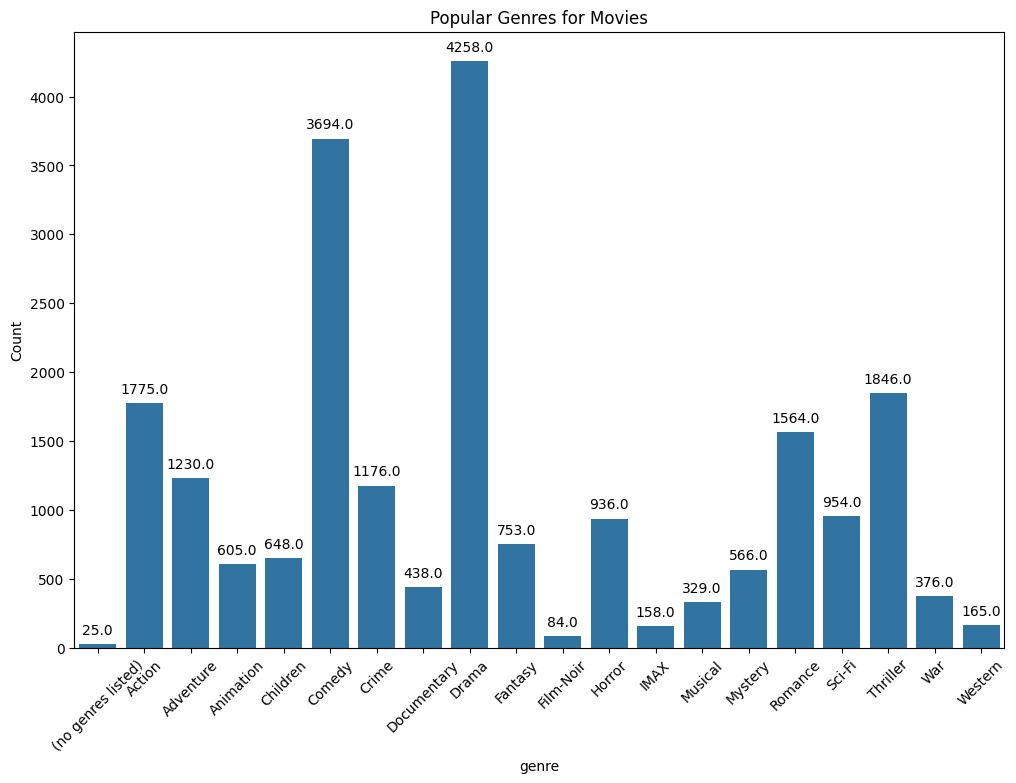

In [16]:
genres_dummies_values = pd.DataFrame(genres_dummies_encoded.sum()).reset_index()
genres_dummies_values = genres_dummies_values.rename(columns = {'index': 'genre', 0:'Count'})

# we add a column for it to represent % of total for each genre
genres_dummies_values['Percentage'] = (genres_dummies_values['Count']/genres_dummies_values.sum()) * 100

# setting figure size
plt.figure(figsize=(12,8))

# barplot
genres_dummies_values_barplot = sns.barplot(data=genres_dummies_values, x='genre', y='Count')
plt.title('Popular Genres for Movies')

# rotating the genres for better readability
plt.xticks(rotation=45)

# labelling bars
for p in genres_dummies_values_barplot.patches:
    genres_dummies_values_barplot.annotate(f'{p.get_height()}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points')
    
# show the plot
plt.show()

For our dataset, Drama seems the most popular genre followed by Comedy and Thriller. Let's explore this deeper, how about for each year what were the most popular genres of movies released?

### Most popular genre of movie by year released for the past 2 decades since 2018
Note: 2018 is the latest year from the dataset

In [17]:
all_genres = genres_dummies['genre'].unique()
all_genres

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Action', 'Crime', 'Thriller', 'Mystery', 'Horror',
       'Drama', 'War', 'Western', 'Sci-Fi', 'Musical', 'Film-Noir',
       'IMAX', 'Documentary', '(no genres listed)'], dtype=object)

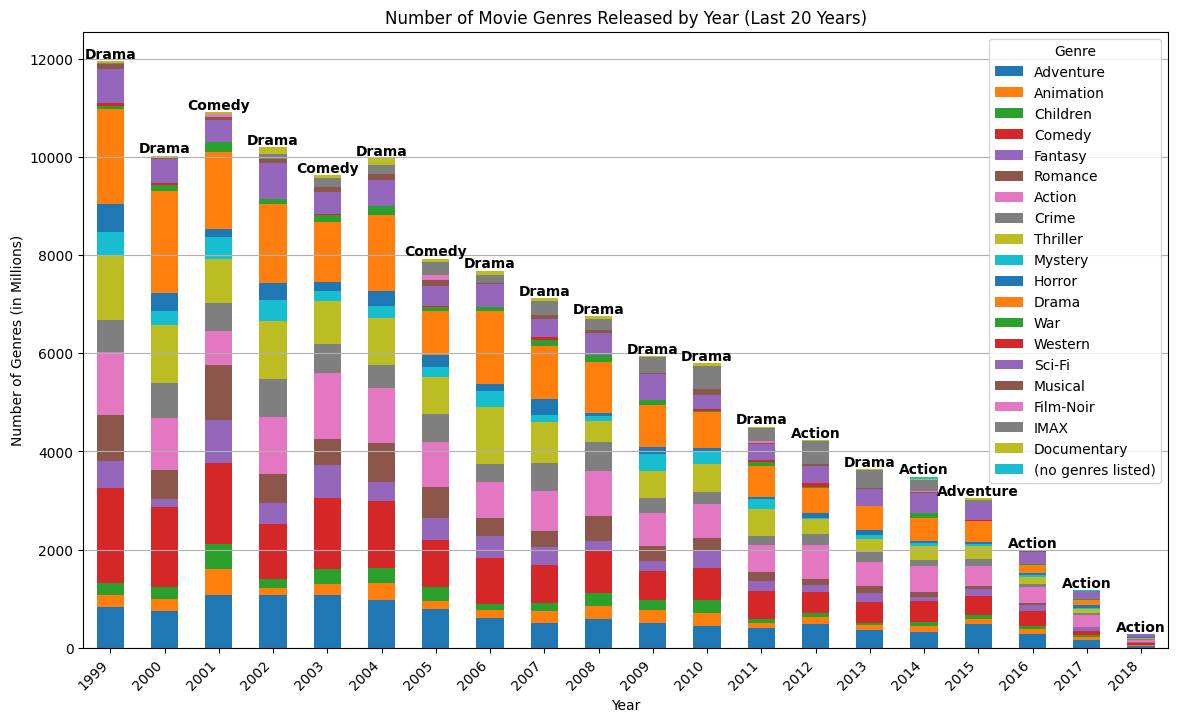

In [18]:
# Sum the genre columns by year
genre_counts_by_year = df.groupby('year')[all_genres].sum()
genre_counts_by_year.index = genre_counts_by_year.index.astype('int')

# Filter data for the last 20 years
last_20_years = genre_counts_by_year.index.max() - 19
filtered_data = genre_counts_by_year[genre_counts_by_year.index >= last_20_years]

# Plotting the data
ax = filtered_data.plot(kind='bar', stacked=True, figsize=(14, 8))

# Customize the plot
plt.title('Number of Movie Genres Released by Year (Last 20 Years)')
plt.xlabel('Year')
plt.ylabel('Number of Genres (in Millions)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Genre')  # Add a legend with title
plt.grid(axis='y')  # Add gridlines for better readability

# annotate the stacked bar chart
for year_idx, year in enumerate(filtered_data.index):
    # Get the most popular genre for the current year
    most_popular_genre = filtered_data.loc[year].idxmax()
    most_popular_value = filtered_data.loc[year].max()
    total_height = filtered_data.loc[year].sum()

    # Annotate the bar
    ax.text(year_idx, total_height, most_popular_genre, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Display the plot
plt.show()

### Correlation between variables
We will use the Pearson Correlation coefficient to find if there are any correlation between `timestamp` and the `rating` of a movie. Note: a Pearson correlation coefficient , $x$ is connsidered:</br>
* No correlation: $x = 0$
* Low degree: $0<x<0.3$
* Moderate degree: $0.3 \leq x<0.5$
* High degree: $0.5\leq x\leq1$


Whethere the value is positive/negative it will indicate a positive/negative relationship between the variables.

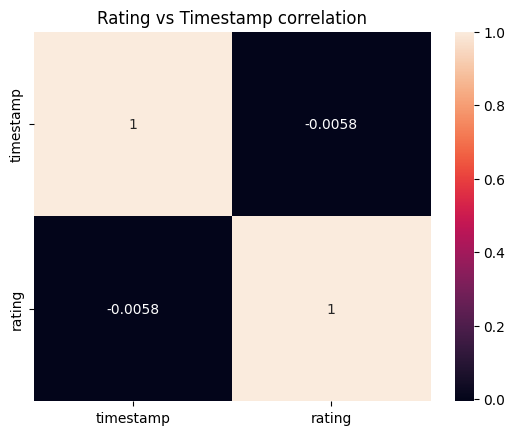

In [19]:
sns.heatmap(df[['timestamp', 'rating']].corr(method='pearson'), annot=True)
plt.title('Rating vs Timestamp correlation')
plt.show()

From our correlation matrix, we find that the timestamp and rating have a very weak negative relationship. This will not provide much substance for us to analyze and build our model so we will omit this from the dataset.

In [20]:
df.drop('timestamp', axis=1, inplace=True)

### Let's see the distribution of all the movie ratings

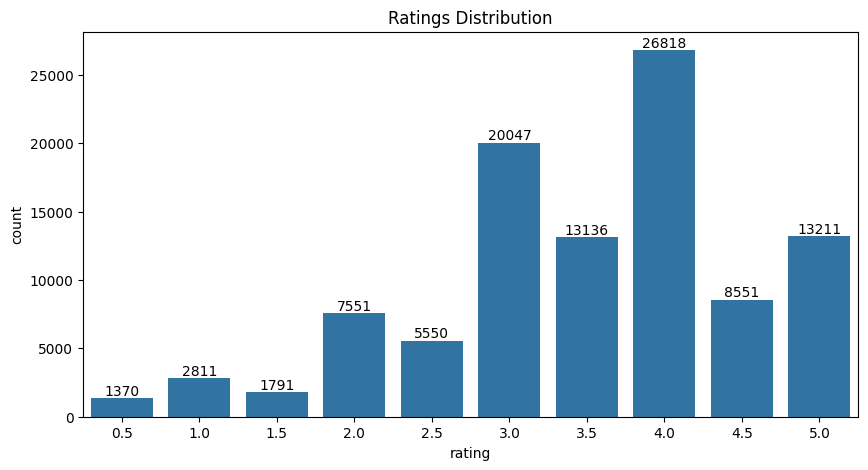

In [21]:
ratings_dist = pd.DataFrame(df['rating'].value_counts())

plt.figure(figsize=(10,5))
plt.title('Ratings Distribution')
ratings_dist_bar = sns.barplot(ratings_dist, x='rating', y='count')
ratings_dist_bar.bar_label(ratings_dist_bar.containers[0])
plt.show()

Observations:</br>
* The barplot of 'Ratings Distribution' suggests that users are ratings movies in increments of 0.5 ranging from 0.5 to 5.
* Data seems to be negatively skewed suggesting there are more positive ratings of movies.
* Large portion of users rate movies in the range [3,4]

### We can also have a look at the top 20 most popular movies

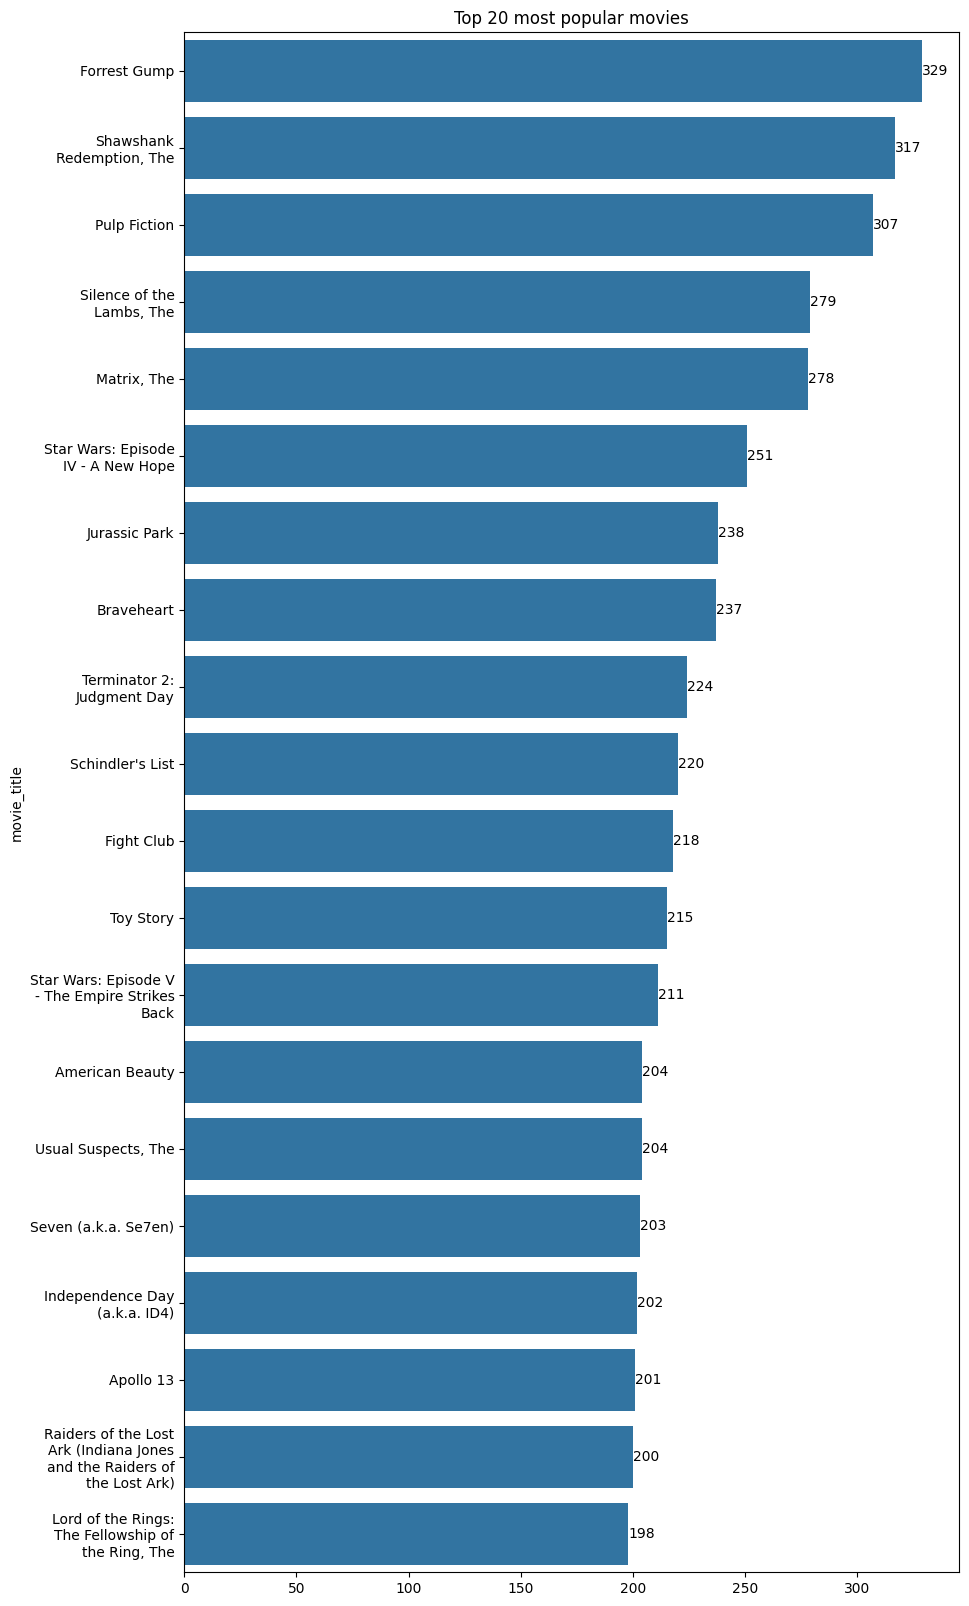

In [55]:
import textwrap

popular_movies = df['movie_title'].value_counts().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,20))
ax = sns.barplot(x=popular_movies.values, y=popular_movies.index, orient="h")
ax.bar_label(ax.containers[0], fontsize=10)
wrapped_labels = [textwrap.fill(label, width=20) for label in popular_movies.index]
plt.yticks(ticks=range(len(popular_movies.index)), labels=wrapped_labels)
plt.title('Top 20 most popular movies')
plt.show()

## Collaborative Filtering
Recommender system based on collaborative filtering, allows the user for more discovery and enhances their exploration based solely on their previous preferences. For this system, we can implement two methods:</br>
* Matrix Factorization - using Singular Value Decomoposition (SVD)</br>
to perform a matrix factorization based on the user ratings for each movie.
* K-Nearest Neighbours</br>
It finds the k users that are closest measured by a specified metric, to the user in question. It then averages the rating those users gave the item we are trying to get a rating for. To calculate the similarity between users, we will use the cosine similarity.</br>

$$
similarity(A,B) = cos(\theta) = \frac {A \cdot B} {\|\mathbf{A}\| \cdot \|\mathbf{B}\|
}$$
Where:
$-1 \le cos(\theta) \le 1$.


### Matrix Factorization

In [22]:
df_collab = df[['userId', 'movie_title', 'rating']].pivot_table(index='userId', columns='movie_title', values='rating', aggfunc='mean')

Evidently, this results in a sparse dataset since it is very unlikely a user has rated all the movies that other users have rated as well. We can calculate the sparsity of the matrix and Singular Value Decomposition (SVD) for matrix factorization. This will help with training our model. </br>
</br>
Before applying SVD, we should normalize our dataframe.

In [23]:
sparsity(df_collab)

The dataframe sparsity is: 98.25%


Normalising our dataframe
It is essential for us to normalize our data before applying SVD since it helps to ensure that each rating contributes equally to the factorization.

In [24]:
avg_movie_rating_by_user = df_collab.mean(axis=1)
df_collab_centred = df_collab.sub(avg_movie_rating_by_user, axis = 0)
df_collab_centred.fillna(0, inplace=True)

# Applying SVD
U, sigma, Vt = svds(df_collab_centred.values)

sigma = np.diag(sigma)

reconstructed_matrix_collab = np.dot(np.dot(U, sigma), Vt)
print(reconstructed_matrix_collab)

[[ 2.03488112e-04  4.94654758e-04 -2.52162744e-04 ... -6.49361575e-03
  -2.17025073e-02  4.43349634e-04]
 [ 1.90448859e-04 -2.65739342e-05  1.64807916e-05 ... -1.94287960e-03
   2.67298018e-03 -1.20928787e-04]
 [ 7.71919800e-04 -2.50957047e-04  9.55022869e-05 ... -5.14537657e-03
   6.05610104e-03 -5.40362392e-04]
 ...
 [ 1.06649016e-02  1.33949943e-03 -8.57368578e-04 ... -1.65715367e-01
  -6.12205272e-02 -1.74351349e-02]
 [ 1.51955956e-04  1.20912851e-04 -4.80238637e-05 ... -3.80580850e-03
  -1.83623471e-03  9.53212195e-06]
 [ 2.35029710e-02  1.10756651e-03 -6.73059633e-04 ... -2.72011062e-01
   1.36098797e-02 -8.56513736e-03]]


#### Reconstructing our matrix and turning it to a dataframe
Note that our reconstructed matrix has values that are centred. We wish to convert it back to uncentered values after applying SVD to make recommendations.</br>
We do this by adding the average back.

In [25]:
reconstructed_matrix_collab_uncentered = reconstructed_matrix_collab + avg_movie_rating_by_user.values.reshape(-1,1)

df_reconstructed_matrix_collab = pd.DataFrame(reconstructed_matrix_collab_uncentered, index=df_collab_centred.index, columns=df_collab_centred.columns)
df_reconstructed_matrix_collab.head(10)

movie_title       '71  'Hellboy': The Seeds of Creation  'Round Midnight  \
userId                                                                     
1            4.373566                          4.373857         4.373110   
2            3.948466                          3.948249         3.948292   
3            2.436669                          2.435646         2.435993   
4            3.553431                          3.556080         3.555352   
5            3.636011                          3.636624         3.636263   
6            3.493832                          3.493321         3.493722   
7            3.233574                          3.232565         3.231490   
8            3.574343                          3.574811         3.574320   
9            3.261168                          3.261035         3.260785   
10           3.277020                          3.278137         3.278745   

movie_title  'Salem's Lot  'Til There Was You  'Tis the Season for Love  \
userId                                                                    
1                4.373416            4.372874                  4.374848   
2                3.948272            3.948338                  3.948071   
3                2.435844            2.436148                  2.435741   
4                3.555825            3.555237                  3.558801   
5                3.636444            3.636177                  3.637962   
6                3.493386            3.493641                  3.483799   
7                3.231914            3.231604                  3.227175   
8                3.574564            3.574213                  3.575017   
9                3.260890            3.260792                  3.259474   
10               3.278439            3.278664                  3.273222   

movie_title  'burbs, The  'night Mother  (500) Days of Summer  \
userId                                                          
1               4.365725       4.371537              4.404674   
2               3.949526       3.948588              3.945044   
3               2.442424       2.438573              2.421093   
4               3.491595       3.545393              3.527977   
5               3.631986       3.634996              3.638929   
6               3.484028       3.489841              3.558705   
7               3.198728       3.223877              3.274970   
8               3.561541       3.571528              3.594638   
9               3.241146       3.257709              3.271410   
10              3.259382       3.274442              3.293563   

movie_title  *batteries not included  ...All the Marbles  \
userId                                                     
1                           4.373124            4.372759   
2                           3.948511            3.948322   
3                           2.439289            2.436053   
4                           3.543721            3.555211   
5                           3.635551            3.636196   
6                           3.489757            3.493700   
7                           3.229382            3.231298   
8                           3.577921            3.574177   
9                           3.258706            3.260668   
10                          3.270866            3.278878   

movie_title  ...And Justice for All  00 Schneider - Jagd auf Nihil Baxter  \
userId                                                                      
1                          4.370206                              4.374940   
2                          3.948916                              3.948207   
3                          2.441488                              2.435152   
4                          3.533638                              3.556434   
5                          3.633726                              3.637038   
6                          3.484600                              3.493494   
7                          3.215161                              3.2

In [26]:
sparsity(df_reconstructed_matrix_collab)

The dataframe sparsity is: 0.00%


We see that the sparsity is now 0%. We were successful in our matrix factorization.
Based on this new dataset, we can now make a recommendation for each of our users. For an example, let us make a recommendation for `userId` = 3.

In [27]:
user3 = df_reconstructed_matrix_collab.loc[3, :].sort_values(ascending=False).head()
user3

movie_title
Star Wars: Episode I - The Phantom Menace    2.514652
Independence Day (a.k.a. ID4)                2.506447
Ace Ventura: Pet Detective                   2.506180
Armageddon                                   2.501578
Dumb & Dumber (Dumb and Dumber)              2.500282
Name: 3, dtype: float64

For `userId` 3 we recommend 'Star Wars: Episode I - The Phantom Menace (1999)' as the next movie to watch based on our matrix factorization model.

### K-Nearest Neighbours
For this recommender system we will use the KNN method for both user-based and item-based recommendations.</br>
### User-Based Recommendations
We will need the centred user-based dataset `df_collab_centered` for this method and the uncentered dataset `df_collab`.
Assume we are providing a recommendation for the userId = 3. For this method, we will train and predict for k-neighbour = 10. </br>
Our user-based recommender system will give suggestions based on predicted ratings for unwatched movies for a user.

In [28]:
rating_counts = df['movie_title'].value_counts()

# we filter out movies that have been rate less than 100 times
movies_rated_more100 = list(rating_counts[rating_counts > 100].index)

In [29]:
# defining our model
user_knn = KNeighborsRegressor(metric = 'cosine', n_neighbors=10)

# give recommendation to user
def user_knn_recommendation_model(user):
    user_movies = df_collab.loc[user].isna()
    unwatched_movies = user_movies[user_movies == True].index.tolist()
    unwatched_movies = list(filter(lambda x: x in movies_rated_more100, unwatched_movies))
    predictions = {}

    for movie in unwatched_movies:
        df_collab_centred_dropped = df_collab_centred.drop(movie, axis=1, inplace=False)
        target_user_x = df_collab_centred_dropped.loc[[user]]
        other_users_y = df_collab[movie]
        other_users_x = df_collab_centred_dropped[other_users_y.notnull()]
        other_users_y_dropped = other_users_y.dropna(inplace=False)

        # training and making a prediction
        # we will only consider movies that have been rated more than 10 times.
        
        n_neighbour = min(10, len(other_users_x))

        if n_neighbour < 10:
            continue

        user_knn.fit(other_users_x, other_users_y_dropped)
        user_user_pred = user_knn.predict(target_user_x)
        predictions[movie] = user_user_pred.tolist()[0]
        sorted_predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))
    return  list(islice(sorted_predictions.items(), 5))

For the unwatched movies of userId 3, here are the 5 movies we recommend the user will enjoy the most based on predicted ratings.

In [30]:
user_knn_recommendation_model(3)

[('Pirates of the Caribbean: The Curse of the Black Pearl', 4.65),
 ('Aliens', 4.6),
 ('Blade Runner', 4.6),
 ('Terminator, The', 4.6),
 ('Usual Suspects, The', 4.6)]

### Item-Based Recommendations</br>
We use the cosine similarity to find the similarities between all the items at once. For this system, we will need a dataframe with items as the index and the users as columns and create a sparse matrix from it. The benefit of using a csr matrix: </br>
* Has faster computations
* It is more memory efficient
* More scalable for larger sparse datasets

For this example of our item-based recommendation model, we will give recommendations to the userId = 3.

In [33]:
# We create a CSR matrix based on the transposed df_collab_centered
csr_item = csr_matrix(df_collab_centred.T.values)

In [34]:
def item_recommender(movie, k):
    '''
    For a given movie, we will provide the top 10 most similar movies based on cosine similarity

    Arg:
        movie: the movie which we are trying to find recommendations for
        k: the number of similar movies we are trying to find.
    
    Returns the k most similar movies to `movie`
    '''
    recommendations = dict()
    movie_index = df_collab_centred.T.index.get_loc(movie)
    movie_vec = csr_item[movie_index]

    item_knn = NearestNeighbors(metric='cosine', n_neighbors=k+1, algorithm='brute') # we use k+1 since the algorithm also counts our movie
    item_knn.fit(csr_item)

    if isinstance(movie_vec, np.ndarray):
        movie_vec = movie_vec.reshape(1,-1)

    distances, indices = item_knn.kneighbors(movie_vec, return_distance=True)

    for i in range(k+1):
        movie_name = df_collab_centred.T.index[indices[0][i]]
        recommendations[movie_name] = distances[0][i]
    
    movie_recommendations = list(recommendations.keys())
    
    print('Because you watched: {}. We recommend you watch:'.format(movie))
    for i in movie_recommendations[1:]:
        print(i)

In [36]:
item_recommender("Toy Story", 4)

Because you watched: Toy Story. We recommend you watch:
Toy Story 2
Toy Story 3
Aladdin
Wallace & Gromit: The Wrong Trousers


Our item based recommender system using kNN has suggested us movies similar to 'Toy Story' - a common theme between them is they are all animated movies. It also makes sense that it recommends 'Toy Story 2' and 'Toy Story 3' since they are the sequel to 'Toy Story'.